In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_auc_score
import warnings
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier


warnings.filterwarnings("ignore")

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
train_data = pd.read_csv("train_kf.csv")
test_data = pd.read_csv("test_kf.csv")


In [3]:
train_data=train_data.sort_values(by=['row_id']).reset_index(drop=True)
test_data=test_data.sort_values(by=['row_id']).reset_index(drop=True)

train_data.head()

,row_id,property_type,loan_purpose,occupancy,preapproval,applicant_ethnicity,applicant_race,applicant_sex,co_applicant,loan_amount,...,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,msa_accept_prob,state_accept_prob,lender_accept_prob,minority,tract_family_income
0,0,1,1,1,3,2,5,1,0,70.0,...,44.230,60588.0,50.933,716.0,2642.0,0.51,0.54,0.84,2743.587,30859.286
1,1,1,3,1,3,1,5,1,0,178.0,...,15.905,54821.0,100.000,1622.0,2108.0,0.54,0.58,0.17,918.355,54821.000
2,2,1,3,1,3,2,5,1,0,163.0,...,61.270,67719.0,100.000,760.0,1048.0,0.51,0.50,0.49,3733.794,67719.000
3,3,1,1,1,1,2,5,1,1,155.0,...,6.246,78439.0,100.000,2025.0,2299.0,0.54,0.55,0.69,416.421,78439.000
4,4,1,1,1,3,2,3,2,0,305.0,...,100.000,63075.0,82.200,1464.0,1847.0,0.52,0.54,0.54,6732.000,51847.650


### 填補遺漏值
* 使用KNN填補遺漏值

In [4]:
withoutNaN=['property_type','loan_purpose','occupancy','preapproval','applicant_ethnicity','applicant_sex','co_applicant','loan_amount','msa_accept_prob','state_accept_prob','lender_accept_prob']
#deal with applicant_income
def NaNwithKNN(data,col):
    data_withNaN=data[data[col].isnull()==True]
    data_withoutNaN=data[data[col].isnull()==False]
    model =KNeighborsRegressor()
    model.fit(data_withoutNaN[withoutNaN],data_withoutNaN[col])
    predict=model.predict(data_withNaN[withoutNaN])
    data_withNaN[col]=predict
    new_data=pd.concat([data_withNaN, data_withoutNaN])
    new_data=new_data.sort_values(by=['row_id']).reset_index(drop=True)

    return new_data


In [5]:
columns=['applicant_income','population','minority_population_pct','ffiecmedian_family_income','tract_to_msa_md_income_pct','number_of_owner-occupied_units','number_of_1_to_4_family_units']
for col in columns:
    train_data=NaNwithKNN(train_data,col)
    test_data=NaNwithKNN(test_data,col)


In [6]:
train_data['minority']=train_data['minority_population_pct']/100*train_data['population']
test_data['minority']=test_data['minority_population_pct']/100*test_data['population']
train_data['tract_family_income']=train_data['tract_to_msa_md_income_pct']/100*train_data['ffiecmedian_family_income']
test_data['tract_family_income']=test_data['tract_to_msa_md_income_pct']/100*test_data['ffiecmedian_family_income']

### 檢查是否還有遺失值

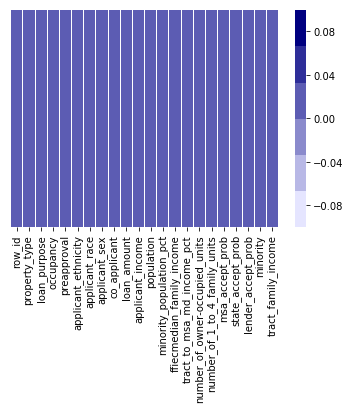

In [7]:
cmap=sns.light_palette("navy", reverse=False)
sns.heatmap(train_data.isnull().astype(np.int8),yticklabels=False,cmap=cmap)
plt.show()

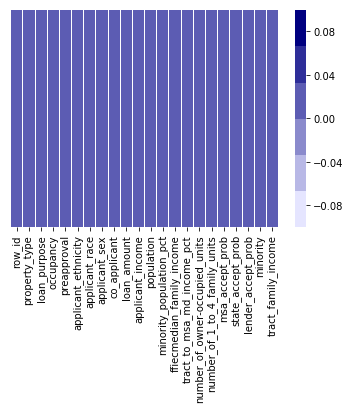

In [8]:
cmap=sns.light_palette("navy", reverse=False)
sns.heatmap(test_data.isnull().astype(np.int8),yticklabels=False,cmap=cmap)
plt.show()

### 將有outlier之變數轉為log

In [9]:
# do log transformation
columns=['loan_amount','applicant_income','population','minority','tract_family_income','number_of_owner-occupied_units','number_of_1_to_4_family_units']
for col in columns:
    train_data[col] = np.log(train_data[col])
    test_data[col] = np.log(test_data[col])


### 建立預測模型

In [10]:
train_labels=pd.read_csv("train_labels.csv")

In [11]:
train_data.columns

Index(['row_id', 'property_type', 'loan_purpose', 'occupancy', 'preapproval',
       'applicant_ethnicity', 'applicant_race', 'applicant_sex',
       'co_applicant', 'loan_amount', 'applicant_income', 'population',
       'minority_population_pct', 'ffiecmedian_family_income',
       'tract_to_msa_md_income_pct', 'number_of_owner-occupied_units',
       'number_of_1_to_4_family_units', 'msa_accept_prob', 'state_accept_prob',
       'lender_accept_prob', 'minority', 'tract_family_income'],
      dtype='object')

### 使用單一模型

In [12]:
def classificationori_model(test_data,model,data, outcome,test_size):
  #Fit the model:
    print("test size:",test_size)
    labels=outcome
    X_train, X_test, y_train, y_test = train_test_split(data, labels,test_size=test_size)
    model.fit(X_train,y_train)
   
   #Make predictions on training set:
    predictions = model.predict(X_test)
    accuracy = metrics.accuracy_score(predictions,y_test)
    print ("Accuracy : " + str(accuracy))
    probabilities = model.predict_proba(X_test)
    #plot_auc(y_test, probabilities)
    kf = KFold(n_splits=5)
    error = []
    for train_index, test_index in kf.split(data):
    # Filter training data
        train_predictors = (data.iloc[train_index,:])
    
    # The target we're using to train the algorithm.
        train_target = labels.iloc[train_index]
    
    # Training the algorithm using the predictors and target.
        model.fit(train_predictors, train_target)
    
    #Record error from each cross-validation run
        error.append(model.score(data.iloc[test_index,:], labels.iloc[test_index]))
     
    print ("Cross-Validation Score :" + str((np.mean(error))))
    

In [13]:
train_data_=train_data
test_data_=test_data
outcome=train_labels['accepted']
model =LogisticRegression(random_state=0, solver='lbfgs',multi_class='ovr')
#M1train_predict_list,M1test_predict_list=
classificationori_model(test_data_,model,train_data_,outcome,.25)

test size: 0.25
Accuracy : 0.51
Cross-Validation Score :0.507378


In [14]:
model =RandomForestClassifier(n_estimators=20)   
classificationori_model(test_data_,model,train_data_,outcome,.25)

test size: 0.25
Accuracy : 0.704968
Cross-Validation Score :0.698196


In [15]:
model = DecisionTreeClassifier()    
classificationori_model(test_data_,model,train_data_,outcome,.25)

test size: 0.25
Accuracy : 0.636896
Cross-Validation Score :0.6227940000000001


In [18]:
model=GradientBoostingClassifier(n_estimators=100, learning_rate=1, max_depth=1, random_state=0)
classificationori_model(test_data_,model,train_data_,outcome,.25)


test size: 0.25
Accuracy : 0.715728
Cross-Validation Score :0.71615


In [21]:
model=XGBClassifier(max_depth=5,n_estimators=100)  
classificationori_model(test_data_,model,train_data_,outcome,.25)


test size: 0.25
Accuracy : 0.724112
Cross-Validation Score :0.723748


### model ensemble 

In [23]:
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from xgboost import XGBClassifier
from vecstack import stacking
from sklearn.metrics import accuracy_score 
from sklearn.neighbors import KNeighborsClassifier 

#KNeighborsClassifier(n_neighbors=5), 
#RandomForestClassifier(random_state=0, n_estimators=100, max_depth=3),     accuacy=0.71953000
#XGBClassifier(random_state=0, learning_rate=0.1, n_estimators=100, max_depth=3)  score:0.7134
outcome=train_labels['accepted']
train_data_stacking=train_data.values
test_data_stacking=test_data.values
X_train, X_test, y_train, y_test = train_test_split(train_data, outcome, test_size=0.2, random_state=0)
models = [ DecisionTreeClassifier(), 
          RandomForestClassifier(random_state=0, n_estimators=100, max_depth=3), 
          XGBClassifier(random_state=0, learning_rate=0.1, n_estimators=100, max_depth=3) ]


S_train, S_test = stacking(models, 
 train_data_stacking,outcome,test_data_stacking, 
 regression=False, 
 
 mode='oof_pred_bag', 
 
 needs_proba=False,
 
 save_dir=None, 
 
 metric=accuracy_score, 
 
 n_folds=4, 
 
 stratified=True,
 
 shuffle=True, 
 
 random_state=0, 
 
 verbose=2)

model = XGBClassifier(random_state=0, learning_rate=0.1, n_estimators=100, max_depth=3) 
model = model.fit(S_train, outcome) 


task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [DecisionTreeClassifier]
    fold  0:  [0.63727490]
    fold  1:  [0.63617891]
    fold  2:  [0.63719710]
    fold  3:  [0.63852511]
    ----
    MEAN:     [0.63729400] + [0.00083199]
    FULL:     [0.63729400]

model  1:     [RandomForestClassifier]
    fold  0:  [0.70666635]
    fold  1:  [0.70767434]
    fold  2:  [0.70891767]
    fold  3:  [0.70468564]
    ----
    MEAN:     [0.70698600] + [0.00154911]
    FULL:     [0.70698600]

model  2:     [XGBClassifier]
    fold  0:  [0.71874625]
    fold  1:  [0.71905025]
    fold  2:  [0.72023776]
    fold  3:  [0.71794174]
    ----
    MEAN:     [0.71899400] + [0.00082443]
    FULL:     [0.71899400]

